In [1]:
%load_ext autoreload
%autoreload 2

## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
30796,00008027_010.png,Atelectasis,10,8027,39,M,PA,2992,2991,0.143,0.143,NaN,/data/images_004/images/00008027_010.png
29648,00007718_001.png,Atelectasis|Consolidation|Effusion|Nodule,1,7718,59,F,PA,2500,2048,0.168,0.168,NaN,/data/images_004/images/00007718_001.png
22149,00005870_002.png,No Finding,2,5870,37,F,AP,2048,2500,0.171,0.171,NaN,/data/images_003/images/00005870_002.png


In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_xray_df['Finding Labels'] =  all_xray_df['Finding Labels'].str.split('|')
all_labels = all_xray_df['Finding Labels'].explode().unique()
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(set)
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda x: 1 if label in x else 0)

In [5]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']  = all_xray_df['Pneumonia'].map(lambda x: 'Pneumonia' if x == 1 else 'Non-pneumonia') 

## Create your training and testing data:

In [6]:
from source.train import create_splits
dev_flag = 1
train_data, val_data = create_splits(all_xray_df,  stratify_on = 'pneumonia_class')
if dev_flag:
    train_data = train_data.sample(1000)

Using TensorFlow backend.


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [7]:
from source.train import my_image_augmentation, make_train_gen, make_val_gen

my_train_idg = my_image_augmentation(horizontal_flip = True,
                         height_shift_range = 0.1,
                         width_shift_range = 0.1,
                         rotation_range = 5,
                         shear_range = 0.05,
                         zoom_range = 0.05)
my_val_idg = my_image_augmentation(horizontal_flip = False,
                         height_shift_range = 0,
                         width_shift_range = 0,
                         rotation_range = 0,
                         shear_range = 0,
                         zoom_range = 0)
train_gen = make_train_gen(my_train_idg, train_data, imgpath_col = 'path', class_col = 'pneumonia_class')
val_gen = make_val_gen(my_val_idg, val_data, imgpath_col = 'path', class_col = 'pneumonia_class')

Found 1000 validated image filenames belonging to 2 classes.
Found 22424 validated image filenames belonging to 2 classes.


In [8]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

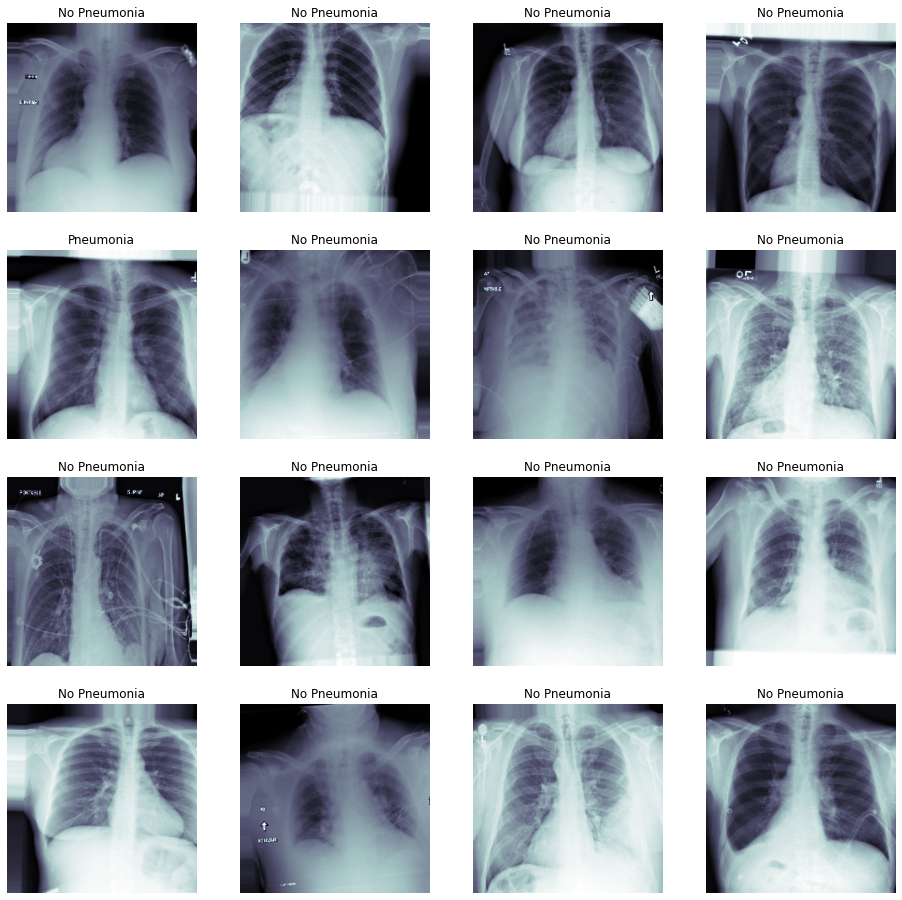

In [9]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [10]:
from source.train import load_pretrained_model
vgg_model = load_pretrained_model()

In [11]:
from source.train import build_my_model
my_model = build_my_model(vgg_model)

In [12]:
from source.train import build_callbacks_list
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
weight_path = "{}_my_model.best.hdf5".format('xray_class')
callbacks_list = build_callbacks_list(weight_path = weight_path)

### Start training! 

In [13]:
from source.train import train

## train your model
history = train(model = my_model,
                callbacks_list = callbacks_list, 
                train_gen = train_gen, 
                validation_data = (valX, valY),
               epochs = 1)

Epoch 1/1
8/8 [==============================] - 31s 4s/step - loss: 0.1376 - binary_accuracy: 0.9900 - val_loss: 0.0019 - val_binary_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00193, saving model to xray_class_my_model.best.hdf5


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [14]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 4s 33ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


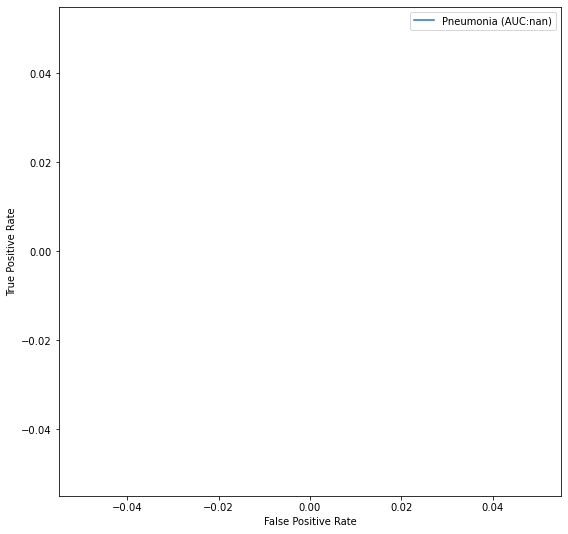

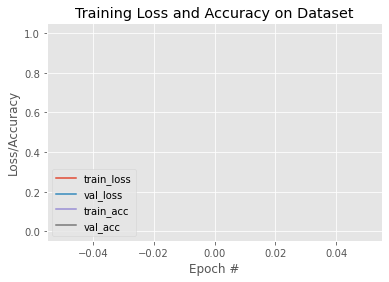

In [15]:
from source.predict import plot_auc, plot_history, calc_f1, plot_history

probability = pred_Y.flatten()
ground_truth = valY
plot_auc(ground_truth, probability)
plot_history(history)    

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [16]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
YOUR_THRESHOLD = 0.5

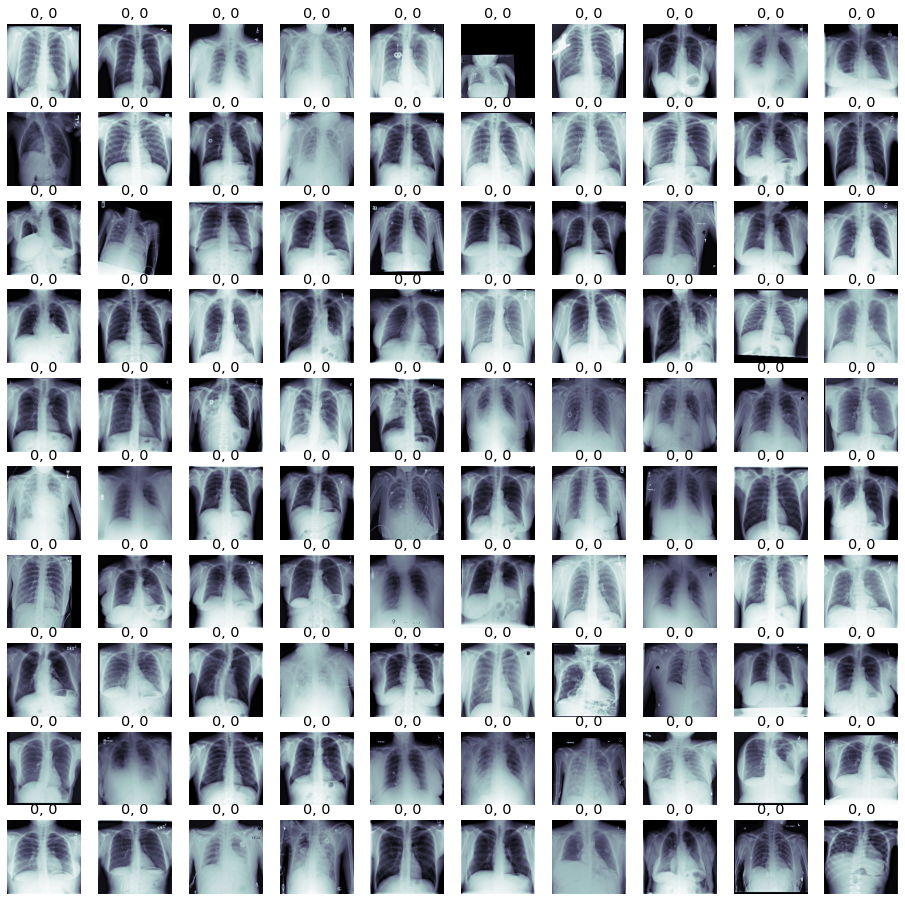

In [17]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [18]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)